# ФИНАЛЬНЫЙ ПРОЕКТ

## ПРОМЫШЛЕННОСТЬ

**ЗАКАЗЧИК**

*Металлургический комбинат ООО «Так закаляем сталь».*

**ЗАДАЧА** 

*Чтобы оптимизировать производственные расходы, Заказчик решил уменьшить потребление электроэнергии на этапе обработки стали.  Требуется построить модель, которая предскажет температуру стали.*

 


**ОПИСАНИЕ ЭТАПА ОБРАБОТКИ**

*Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитированными электродами. Они установлены в крышке ковша.*

*Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).*

*Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.*

*Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).*


**Цель исследования**:
- построение модели для предсказания температуру стали.

**Данные**

*состоят из файлов, полученных из разных источников:*

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` — данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

*Во всех файлах столбец **key** содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.*


**Ход исследования**

1. ЭТАП Подготовка данных

    - преобразование типов данных 
    - удаление лишних временных меток
    - обработка пропусков и выбросов
    - анализ событий в течение одного цикла плавки, посчитать информацию по партиям
    - оставить только необходимые для обучения признаки
    - объединить необходимые данные в одну таблицу по ключам (key)
    

2. ЭТАП Подготовка признаков: создание таблицы со всеми данными для модели, определение целевого признака:
    - разделить датасет на тестовую и валидационную выборки
    - проверить равномерность выборок
    

3. ЭТАП Выбор регрессионных моделей (CatBoostRegressor, LGBMRegressor и т.д.) и сравнение качества предсказаний^
    - RANDOM_STATE = 12092022 
    - тестовая выборка - 20%
    - Будем использовать подбор параметров  с использованием GridSearchCV.
    - Будем искать лучшую модель на train-выборке (подбор моделей).
    - На train-выборке будем проверять ТОЛЬКО лучшую модель.
    - Метрика: МАЕ (не более 8.7) 


4. ЭТАП Оценка эффективности модели на тестовой выборке.


5. ЭТАП Выводы

**Дополнитльено на 1 этапе НАЙТИ:**
- Длительность времени между первым и последним замером температуры.
- Суммарное время нагрева электродами, то есть сумму значений по всем промежуткам между запусками нагрева электродов.
- Количество запусков нагрева электродами.
- Среднее соотношение потребления активной и реактивной мощности.
- По всем полученным столбцам вычислите статистики: средние, минимальные и максимальные значения, медиану и величины 25%- и 75%-квартилей.


## Загрузка данных

In [75]:
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [2]:
way = '/datasets/final_steel/'


data_arc = pd.read_csv(way + 'data_arc.csv')
data_bulk = pd.read_csv(way + 'data_bulk.csv')
data_bulk_time = pd.read_csv(way + 'data_bulk_time.csv')
data_gas = pd.read_csv(way + 'data_gas.csv')
data_temp = pd.read_csv(way + 'data_temp.csv')
data_wire = pd.read_csv(way + 'data_wire.csv')
data_wire_time = pd.read_csv(way + 'data_wire_time.csv')

## Информация о файлах

In [3]:
#функция для получения информации о файлах

def data_info(data):
    print(color.BOLD + 'ОБЩАЯ ИНФОРМАЦИЯ' + color.END)    
    #print('-'*78)
    data.info()
    
    print(' ')
    print(color.BOLD + 'ДАННЫЕ ТАБЛИЦЫ' + color.END)    
    #print('-'*78)
    display(data.head(10))
    
    print(' ')
    print(color.BOLD + 'ОПИСАТЕЛЬНАЯ СТАТИСТИКА' + color.END)    
    #print('-'*78)
    display(data.describe())
    
    print(' ')
    print(color.BOLD + 'КОЛИЧЕСТВО ДУБЛИКАТОВ' + color.END)    
    display(data.duplicated().sum())
    
    print(' ')
    print(color.BOLD + 'КОЛИЧЕСТВО ПРОПУСКОВ' + color.END)    
    display(data.isnull().sum())

### Данные об электродах

In [4]:
data_info(data_arc)

ОБЩАЯ ИНФОРМАЦИЯ
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
 
ДАННЫЕ ТАБЛИЦЫ


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


 
ОПИСАТЕЛЬНАЯ СТАТИСТИКА


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


 
КОЛИЧЕСТВО ДУБЛИКАТОВ


0

 
КОЛИЧЕСТВО ПРОПУСКОВ


key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

Файл *data_arc* с информацией о нагреве стали электродами:
- названия столбцов на англ и рус языках (с пробелами)
- пропуски в данных отсутствуют
- дубликаты отсутствуют
- 14876 строк
- партии: от 1 до 3241 
- столбцы с началом и концом процесса нагрева (требуют изменения типа данных с object на datetime !!!)
- столбцы с активной мощностью (фактической мощностью) и реактивной мощностью (бесполезной мощностью)
- min реактивной мощности *-715* (возможно выброс - !!проверить!!)


Из файла data_arc возможно рассчитать полную мощность, потраченную при нагреве стали дугой: комбинация реактивной и активной мощностей (Полная мощность = √ (Активная мощность2 + Реактивная мощность2)) и/или *соотношение потребления активной и реактивной мощности*.
Потребуется вычислить дополнительно длительность нагрева (*суммарное время нагрева электродами, то есть сумму значений по всем промежуткам между запусками нагрева электродов*).

**Переименование столбцов**

In [5]:
data_arc.rename(columns={'Начало нагрева дугой': 'start_arc_heat',
                                    'Конец нагрева дугой': 'end_arc_heat',
                                    'Активная мощность': 'active_power',
                                    'Реактивная мощность': 'reactive_power'}, inplace=True)

**Приведем данные к нужному типу:**

In [6]:
data_arc['start_arc_heat'] = pd.to_datetime(data_arc['start_arc_heat'], format='%Y-%m-%dT%H:%M:%S')
data_arc['end_arc_heat'] = pd.to_datetime(data_arc['end_arc_heat'], format='%Y-%m-%dT%H:%M:%S')

**Проверим отрицательную реактивную мощность:**

In [7]:
data_arc[data_arc['reactive_power'] < 0]

,key,start_arc_heat,end_arc_heat,active_power,reactive_power
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


Проверим партию key=2116: если строка с отрицательной реактивной мощностью последняя по партии, то лучше удалить всю партию, т.к. последяя строка - целевая !!! и в случае просто удаления строки с отрицательной реактивной мощностью, мы подставим потом не последнюю температуру по пратии, что может сказаться на обучении.

In [8]:
display(data_arc[data_arc['key'] ==2116])

,key,start_arc_heat,end_arc_heat,active_power,reactive_power
9778,2116,2019-07-24 00:29:52,2019-07-24 00:31:54,0.433266,0.306141
9779,2116,2019-07-24 00:35:50,2019-07-24 00:38:05,0.620265,0.408352
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924
9781,2116,2019-07-24 00:51:51,2019-07-24 00:52:58,0.299368,0.198796


Итак, строка не последняя в партии, значит просто уберем ее:

In [9]:
data_arc = data_arc[data_arc['reactive_power'] >= 0]
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14875 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             14875 non-null  int64         
 1   start_arc_heat  14875 non-null  datetime64[ns]
 2   end_arc_heat    14875 non-null  datetime64[ns]
 3   active_power    14875 non-null  float64       
 4   reactive_power  14875 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 697.3 KB


**Посчитаем длительность нагрева по каждой итерации обработки:**

In [10]:
data_arc['duration_heat_sec'] = (data_arc['end_arc_heat'] - data_arc['start_arc_heat']).dt.total_seconds()
#уберем информацию о времени
data_arc = data_arc.drop(columns=['start_arc_heat','end_arc_heat'])

In [11]:
data_arc.head()

,key,active_power,reactive_power,duration_heat_sec
0,1,0.976059,0.687084,228.0
1,1,0.805607,0.520285,185.0
2,1,0.744363,0.498805,172.0
3,1,1.659363,1.062669,365.0
4,1,0.692755,0.414397,148.0


**Посчитаем суммарное время нагрева электродами по каждой партии (key)**

In [12]:
data_arc_key= data_arc.groupby('key')['duration_heat_sec'].sum()
data_arc_key=data_arc_key.reset_index()
data_arc_key.columns=['key','duration_heat_sec']
data_arc_key

,key,duration_heat_sec
0,1,1098.0
1,2,811.0
2,3,655.0
3,4,741.0
4,5,869.0
...,...,...
3209,3237,909.0
3210,3238,546.0
3211,3239,1216.0
3212,3240,839.0


**Проверим распределение мощностей**

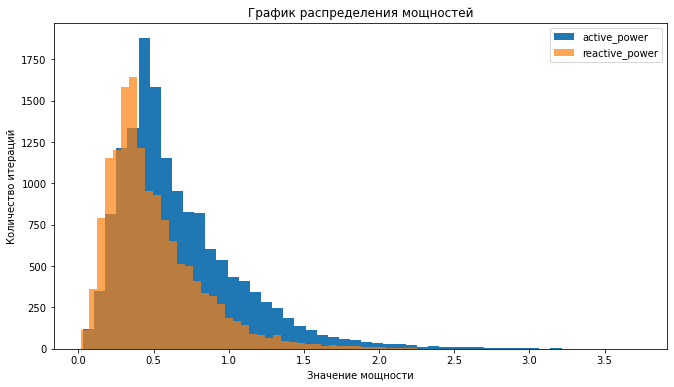

In [13]:
plt.figure(figsize=(11,6))
data_arc['active_power'].plot(kind='hist', bins=50, legend=True)
data_arc['reactive_power'].plot(kind='hist', bins=50, legend=True, alpha=0.7)
plt.title('График распределения мощностей')
plt.xlabel('Значение мощности')
plt.ylabel('Количество итераций')
plt.show()



Видим нормальное распределение мощностей со смещением влево.

**Проверим корреляцию Активной и Реактивной мощности**

Корреляция Активной и Реактивной мощности 0.9631819131519804


<Figure size 1440x720 with 0 Axes>

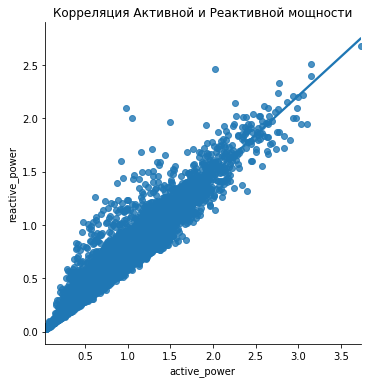

In [14]:
print('Корреляция Активной и Реактивной мощности', data_arc['active_power'].corr(data_arc['reactive_power']))
plt.figure(figsize=(20,10))
sns.lmplot(x='active_power', y='reactive_power', data=data_arc)
plt.title('Корреляция Активной и Реактивной мощности')
plt.show()



Корреляция близка к единице, поэтому попробуем для дальнейшего анализа использоваьб полную мощность!

**Посчитаем полную мощность**, потраченную при нагреве стали дугой: комбинация реактивной и активной мощностей (Полная мощность = √ (Активная мощность2 + Реактивная мощность2))

In [15]:
data_arc['full_power'] = np.sqrt(data_arc['active_power']**2 + data_arc['reactive_power']**2)

**Посчитаем соотношение потребления активной и реактивной мощности:**

In [16]:
data_arc['ratio_act_react'] = data_arc['active_power']/data_arc['reactive_power']

Посмотрим на таблицу с другой стороны - по каждой партии найдем средние значения по всем итерациям (в данном случае среднее время нагрева нас не интересует):

In [17]:
data_arc_mean = data_arc.drop(columns='duration_heat_sec').groupby(by='key').mean().reset_index()
data_arc_mean 

,key,active_power,reactive_power,full_power,ratio_act_react
0,1,0.975629,0.636648,1.165279,1.538898
1,2,0.763150,0.499528,0.912304,1.551834
2,3,0.505176,0.319815,0.597907,1.583120
3,4,0.802313,0.515074,0.953741,1.563487
4,5,0.836793,0.563161,1.008939,1.480428
...,...,...,...,...,...
3209,3237,0.786493,0.565692,0.968996,1.384203
3210,3238,0.702176,0.560394,0.898847,1.257794
3211,3239,0.583344,0.388952,0.701485,1.497918
3212,3240,0.596817,0.496653,0.778371,1.257343


Посмотрим на корреляцию признаков:

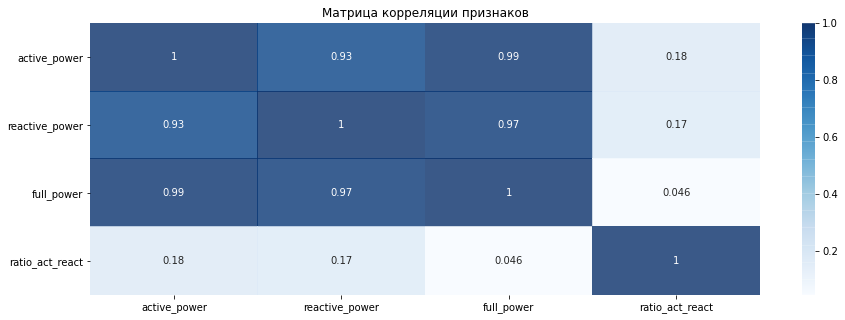

In [18]:
plt.figure(figsize=(15, 5))
sns.heatmap(data_arc_mean[['active_power', 'reactive_power', 
    'full_power', 'ratio_act_react']].corr().abs(), cmap='Blues', alpha=0.8,
           annot=True);
plt.title('Матрица корреляции признаков')
plt.show()

Наглядно видим, что наблюадется корреляция между active_power, reactive_power и full_power. Поэтому оставим только full_power (как комбинацию мощностей):

In [19]:
data_arc_mean = data_arc_mean.drop(columns = ['active_power', 'reactive_power'])
data_arc_mean

,key,full_power,ratio_act_react
0,1,1.165279,1.538898
1,2,0.912304,1.551834
2,3,0.597907,1.583120
3,4,0.953741,1.563487
4,5,1.008939,1.480428
...,...,...,...
3209,3237,0.968996,1.384203
3210,3238,0.898847,1.257794
3211,3239,0.701485,1.497918
3212,3240,0.778371,1.257343


**Посчитаем количество запусков нагрева электродов** по каждой партии:

In [20]:
data_arc_count = data_arc.groupby('key')['duration_heat_sec'].count().reset_index()
data_arc_count.columns=['key','count_heat']
data_arc_count

,key,count_heat
0,1,5
1,2,4
2,3,5
3,4,4
4,5,4
...,...,...
3209,3237,5
3210,3238,3
3211,3239,8
3212,3240,5


Объединим таблицы data_arc_key, data_arc_count и data_arc_mean по key:

In [21]:
data_arc_merge = data_arc_key.merge(data_arc_count,how='left', on='key').merge(data_arc_mean,how='left', on='key')
data_arc_merge

,key,duration_heat_sec,count_heat,full_power,ratio_act_react
0,1,1098.0,5,1.165279,1.538898
1,2,811.0,4,0.912304,1.551834
2,3,655.0,5,0.597907,1.583120
3,4,741.0,4,0.953741,1.563487
4,5,869.0,4,1.008939,1.480428
...,...,...,...,...,...
3209,3237,909.0,5,0.968996,1.384203
3210,3238,546.0,3,0.898847,1.257794
3211,3239,1216.0,8,0.701485,1.497918
3212,3240,839.0,5,0.778371,1.257343


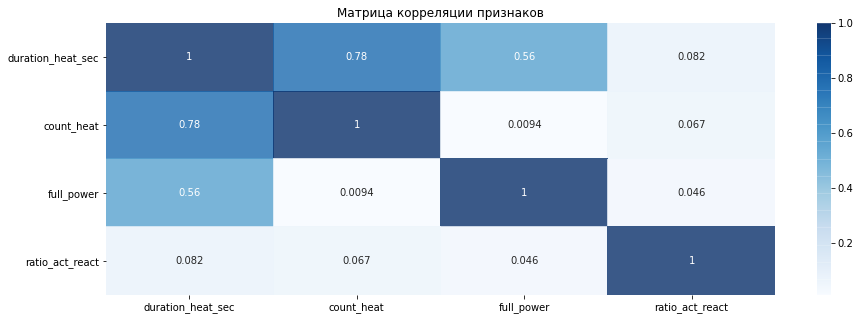

In [22]:
plt.figure(figsize=(15, 5))
sns.heatmap(data_arc_merge.drop(columns = 'key').corr().abs(), cmap='Blues', alpha=0.8,
           annot=True);
plt.title('Матрица корреляции признаков')
plt.show()

Видно, что Длительность нагрева в секундах коррелирует с количеством запусков нагрева электродами. Пока оставим оба признака.  В дальнейшем для обучения примем решение, какой из признаков (или оба?) оставим в данных!

**//мерой мультиколлинеарности берут значение 0.9//**

### Данные о подаче сыпучих материалов (объём)

In [23]:
data_info(data_bulk)

ОБЩАЯ ИНФОРМАЦИЯ
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
 
ДАННЫЕ ТАБЛИЦЫ


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


 
ОПИСАТЕЛЬНАЯ СТАТИСТИКА


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


 
КОЛИЧЕСТВО ДУБЛИКАТОВ


0

 
КОЛИЧЕСТВО ПРОПУСКОВ


key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

Файл *data_bulk* с информацией о подаче сыпучих материалов:
- пропуски в данных присутствуют (что логично, тк добавляют то или иное количество материалов)
- дубликаты отсутствуют
- 3129 строк
- партии от 1 до 3241 (значит не во все партии шли добавки) 
- столбцы содержат информацию об объеме той или иной добавки 
- разве что по *Bulk 8* может быть вопрос - представлен в количестве 1 строки (но на результате вряд ли скажется)
- судить о выбросах довольно сложно, тк нет информации об изначальных сплавах и о добавках

**Посмотрим на график распределения всех сыпучих материалов:**

array([[<AxesSubplot:title={'center':'Bulk 1'}>,
        <AxesSubplot:title={'center':'Bulk 2'}>,
        <AxesSubplot:title={'center':'Bulk 3'}>,
        <AxesSubplot:title={'center':'Bulk 4'}>],
       [<AxesSubplot:title={'center':'Bulk 5'}>,
        <AxesSubplot:title={'center':'Bulk 6'}>,
        <AxesSubplot:title={'center':'Bulk 7'}>,
        <AxesSubplot:title={'center':'Bulk 8'}>],
       [<AxesSubplot:title={'center':'Bulk 9'}>,
        <AxesSubplot:title={'center':'Bulk 10'}>,
        <AxesSubplot:title={'center':'Bulk 11'}>,
        <AxesSubplot:title={'center':'Bulk 12'}>],
       [<AxesSubplot:title={'center':'Bulk 13'}>,
        <AxesSubplot:title={'center':'Bulk 14'}>,
        <AxesSubplot:title={'center':'Bulk 15'}>, <AxesSubplot:>]],
      dtype=object)

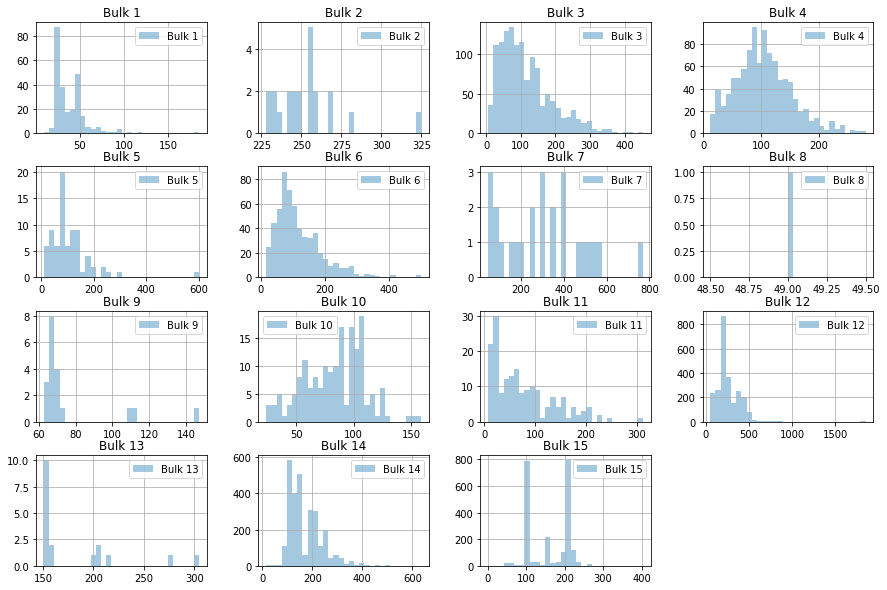

In [27]:
columns = data_bulk.drop(columns = 'key')
columns.hist(bins=30, figsize=(15,10),legend=True,  alpha=0.4)

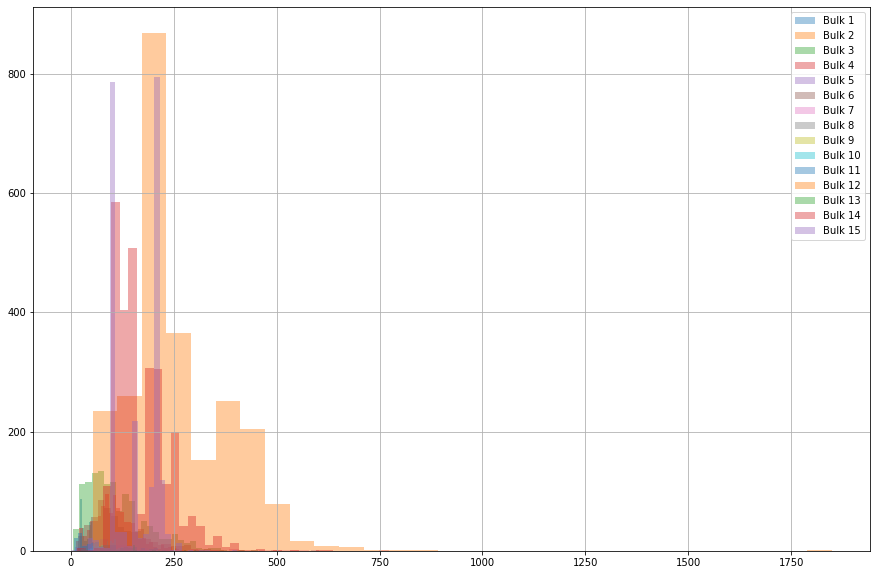

In [28]:
for column in data_bulk.columns:
    if column[0] == 'B':
        data_bulk[column].hist(bins=30, figsize=(15,10),legend=True,  alpha=0.4)

По гистограмме видно, что некоторые присадки в меньшем количестве, распределения имеют нормальный вид.

**Заменим пропуски на ноль:**

In [29]:
data_bulk = data_bulk.fillna(0)

array([[<AxesSubplot:title={'center':'Bulk 1'}>,
        <AxesSubplot:title={'center':'Bulk 2'}>,
        <AxesSubplot:title={'center':'Bulk 3'}>,
        <AxesSubplot:title={'center':'Bulk 4'}>],
       [<AxesSubplot:title={'center':'Bulk 5'}>,
        <AxesSubplot:title={'center':'Bulk 6'}>,
        <AxesSubplot:title={'center':'Bulk 7'}>,
        <AxesSubplot:title={'center':'Bulk 8'}>],
       [<AxesSubplot:title={'center':'Bulk 9'}>,
        <AxesSubplot:title={'center':'Bulk 10'}>,
        <AxesSubplot:title={'center':'Bulk 11'}>,
        <AxesSubplot:title={'center':'Bulk 12'}>],
       [<AxesSubplot:title={'center':'Bulk 13'}>,
        <AxesSubplot:title={'center':'Bulk 14'}>,
        <AxesSubplot:title={'center':'Bulk 15'}>, <AxesSubplot:>]],
      dtype=object)

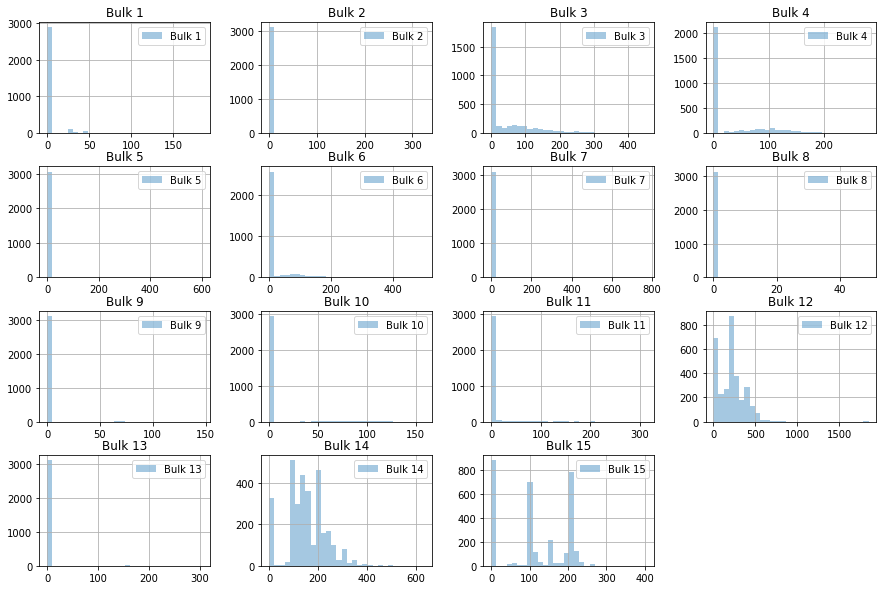

In [30]:
columns = data_bulk.drop(columns = 'key')
columns.hist(bins=30, figsize=(15,10),legend=True,  alpha=0.4)

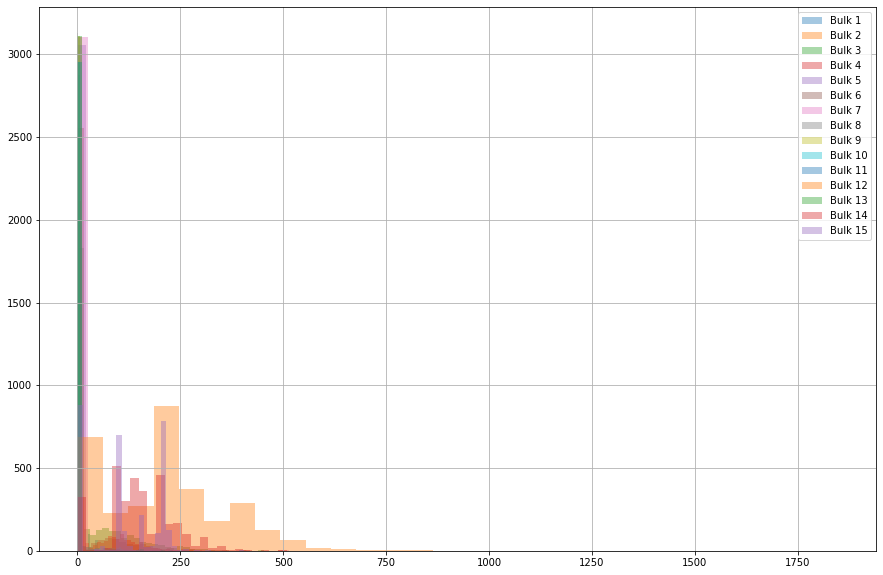

In [26]:
# и еще раз взглянем на гистограмму
for column in data_bulk.columns:
    if column[0] == 'B':
        data_bulk[column].hist(bins=30, figsize=(15,10),legend=True,  alpha=0.4)

Видно, что несколько присадок с графика сместились к нулю!

**Проверим корреляцию признаков:**

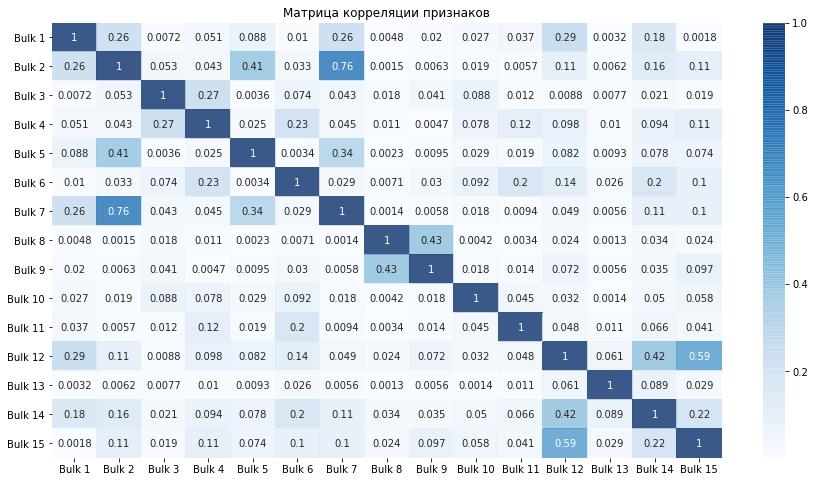

In [31]:
plt.figure(figsize=(15, 8))
sns.heatmap(data_bulk.drop(columns='key').corr().abs(), cmap='Blues', alpha=0.8,
           annot=True);
plt.title('Матрица корреляции признаков')
plt.show()

Сильной коррелиции не наблюдается, **НО** Есть сыпучие материалы, которых, судя по info и hist больше по объему и которые могут сыграть большую роль в предсказании и обучении модели:

- Bulk 3, Bulk 4, Bulk 12, Bulk 14, Bulk 15.

Оставим только их:

In [32]:
data_bulk = data_bulk[['key', 'Bulk 3','Bulk 4','Bulk 12','Bulk 14','Bulk 15']]
data_bulk

,key,Bulk 3,Bulk 4,Bulk 12,Bulk 14,Bulk 15
0,1,0.0,43.0,206.0,150.0,154.0
1,2,0.0,73.0,206.0,149.0,154.0
2,3,0.0,34.0,205.0,152.0,153.0
3,4,0.0,81.0,207.0,153.0,154.0
4,5,0.0,78.0,203.0,151.0,152.0
...,...,...,...,...,...,...
3124,3237,170.0,0.0,252.0,130.0,206.0
3125,3238,126.0,0.0,254.0,108.0,106.0
3126,3239,0.0,0.0,158.0,270.0,88.0
3127,3240,0.0,0.0,0.0,192.0,54.0


### Данные о подаче сыпучих материалов (время):


In [33]:
data_info(data_bulk_time)

ОБЩАЯ ИНФОРМАЦИЯ
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB
 
ДАННЫЕ ТАБЛИЦЫ


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
5,6,NaN,NaN,NaN,2019-05-03 13:59:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:53:27,NaN,2019-05-03 13:53:27,2019-05-03 13:53:27
6,7,NaN,NaN,NaN,2019-05-03 14:29:14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:22:19,NaN,2019-05-03 14:22:19,2019-05-03 14:22:19
7,8,NaN,NaN,NaN,2019-05-03 15:04:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:55:46,NaN,2019-05-03 14:55:46,2019-05-03 14:55:46
8,9,NaN,NaN,NaN,2019-05-03 15:47:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:41:00,NaN,2019-05-03 15:41:00,2019-05-03 15:41:00
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:18:52,NaN,2019-05-03 16:18:52,2019-05-03 16:18:52


 
ОПИСАТЕЛЬНАЯ СТАТИСТИКА


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


 
КОЛИЧЕСТВО ДУБЛИКАТОВ


0

 
КОЛИЧЕСТВО ПРОПУСКОВ


key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

Файл *data_bulk_time* с информацией о времени подачи сыпучих материалов:
- пропуски в данных присутствуют (что логично, тк добавляют то или иное количество материалов)
- дубликаты отсутствуют
- 3129 строк
- партии от 1 до 3241 (значит не во все партии шли добавки) 

**Необходимость** данной таблицы в дальнейшем под вопрсом. Для обучения модели вряд ли пригодится! Нет смысла в обработке пропусков или выборе тех или иных Bulk (как в data_bulk).

###  Данные о продувке сплава газом

In [34]:
data_info(data_gas)

ОБЩАЯ ИНФОРМАЦИЯ
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
 
ДАННЫЕ ТАБЛИЦЫ


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


 
ОПИСАТЕЛЬНАЯ СТАТИСТИКА


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


 
КОЛИЧЕСТВО ДУБЛИКАТОВ


0

 
КОЛИЧЕСТВО ПРОПУСКОВ


key      0
Газ 1    0
dtype: int64

Файл *data_gas* с информацией о продувке сплава газом (объем используемого газа на партию):
- названия столбцов на англ и рус языках (с пробелами)
- пропуски в данных отсутствуют 
- дубликаты отсутствуют
- 3239 строк
- партии от 1 до 3241 (значит по ДВУМ партиям не шла продувка) 

**Переименование столбцов**

In [35]:
data_gas.rename(columns={'Газ 1': 'gas'}, inplace=True)

### Результаты измерения температуры

In [36]:
data_info(data_temp)

ОБЩАЯ ИНФОРМАЦИЯ
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB
 
ДАННЫЕ ТАБЛИЦЫ


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


 
ОПИСАТЕЛЬНАЯ СТАТИСТИКА


,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


 
КОЛИЧЕСТВО ДУБЛИКАТОВ


0

 
КОЛИЧЕСТВО ПРОПУСКОВ


key                0
Время замера       0
Температура     2901
dtype: int64

Файл *data_temp* с информацией о результатах измерения температуры на разных итерациях:
- названия столбцов на англ и рус языках (с пробелами)
- неверный формат даты
- пропуски в данных имеются по столбцу температуры
- дубликаты отсутствуют
- 15907 строк
- партии: от 1 до 3241 
- требуется проверка выбросов

**Переименование столбцов**

In [37]:
data_temp.rename(columns={'Температура': 'temp','Время замера': 'measure_time'}, inplace=True)

**Приведем данные к нужному типу**

In [38]:
data_temp['measure_time'] = pd.to_datetime(data_temp['measure_time'], format='%Y-%m-%dT%H:%M:%S')

**Проверим номера партий, в которых есть пропуски:**

In [39]:
display(sorted(data_temp[data_temp.isnull().any(axis=1)].key.unique ()))

[2500,
 2501,
 2502,
 2503,
 2504,
 2505,
 2506,
 2507,
 2508,
 2509,
 2510,
 2511,
 2512,
 2513,
 2514,
 2515,
 2516,
 2517,
 2518,
 2519,
 2520,
 2521,
 2522,
 2523,
 2524,
 2525,
 2526,
 2527,
 2528,
 2529,
 2530,
 2531,
 2532,
 2533,
 2534,
 2535,
 2536,
 2537,
 2538,
 2539,
 2540,
 2541,
 2542,
 2543,
 2544,
 2545,
 2546,
 2547,
 2548,
 2549,
 2550,
 2551,
 2552,
 2553,
 2554,
 2555,
 2556,
 2557,
 2558,
 2559,
 2560,
 2561,
 2562,
 2563,
 2564,
 2565,
 2566,
 2567,
 2568,
 2569,
 2570,
 2571,
 2572,
 2573,
 2574,
 2575,
 2576,
 2577,
 2578,
 2579,
 2580,
 2581,
 2582,
 2583,
 2584,
 2585,
 2586,
 2587,
 2588,
 2589,
 2590,
 2591,
 2592,
 2593,
 2594,
 2595,
 2596,
 2597,
 2598,
 2599,
 2600,
 2601,
 2602,
 2603,
 2604,
 2605,
 2606,
 2607,
 2608,
 2609,
 2610,
 2611,
 2612,
 2613,
 2614,
 2615,
 2616,
 2617,
 2618,
 2619,
 2620,
 2621,
 2622,
 2623,
 2624,
 2625,
 2626,
 2627,
 2628,
 2629,
 2630,
 2631,
 2632,
 2633,
 2634,
 2635,
 2636,
 2637,
 2638,
 2639,
 2640,
 2641,
 2642,

Видно, что с партии 2500 в каждой партии наблюдаются пропуски по тепературе. Удалим все эти партии:

In [40]:
data_temp = data_temp[data_temp['key'] < 2500]

In [41]:
data_temp

,key,measure_time,temp
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
12262,2498,2019-08-06 02:19:26,1593.0
12263,2498,2019-08-06 02:25:31,1594.0
12264,2499,2019-08-06 02:40:25,1569.0
12265,2499,2019-08-06 02:54:24,1604.0


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


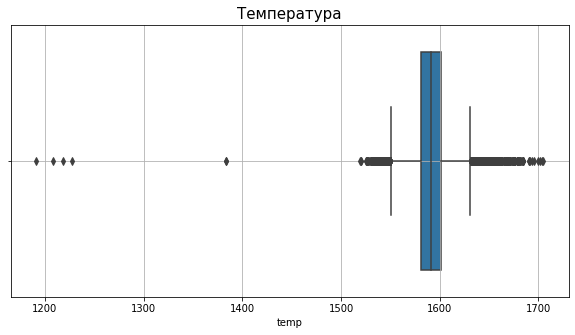

In [42]:
#проверим наличие выбросов
plt.figure(figsize=(10,5))
sns.boxplot(data_temp['temp'])
plt.title('Температура', fontsize=15)
plt.grid(True)
plt.show()

Выбросы наблюдаются. Однако  в случае с температурой плавления: по справочнику она у металла = около 1400+-, т.е. 1200 - действиетльно кажется очень странным значением. А 1450 и выше выглядит вполне рабочим. Скорректируем наши данные с учетом этого:

In [43]:
data_temp = data_temp.query('temp>=1400 and temp<=1650')

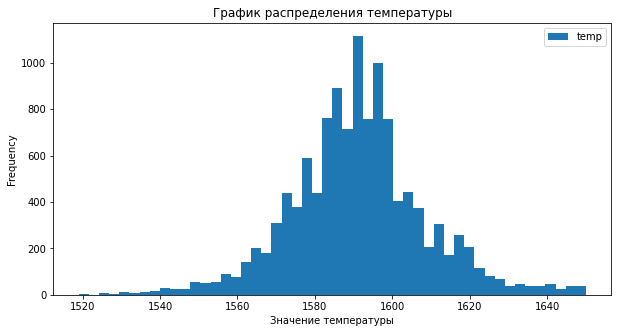

In [44]:
plt.figure(figsize=(10,5))
data_temp['temp'].plot(kind='hist', bins=50, legend=True)
plt.title('График распределения температуры')
plt.xlabel('Значение температуры')
plt.show()

In [45]:
data_temp.head(15)

,key,measure_time,temp
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


Таблица в таком формате данных нам не так интересна. Посмотрим на первый и последний замер температуры в пределах одного key:

In [46]:
data_temp_pivot = data_temp.pivot_table(index='key', aggfunc=['max','min'])
data_temp_pivot=data_temp_pivot.reset_index()
data_temp_pivot.columns=['key', 'measure_time', 'temp_end','time_start', 'temp_start']
data_temp_pivot.head()

,key,measure_time,temp_end,time_start,temp_start
0,1,2019-05-03 11:30:39,1618.0,2019-05-03 11:16:18,1571.0
1,2,2019-05-03 11:59:12,1608.0,2019-05-03 11:37:27,1577.0
2,3,2019-05-03 12:34:57,1599.0,2019-05-03 12:13:17,1596.0
3,4,2019-05-03 12:59:25,1625.0,2019-05-03 12:52:57,1601.0
4,5,2019-05-03 13:36:01,1602.0,2019-05-03 13:23:19,1576.0


Температура в конце не соответствует данным таблицы data_temp по указанному времени конца, удалим столбец, НО добавим столбец температуры из таблицы data_temp:

In [47]:
data_temp_pivot = data_temp_pivot.drop(columns=['temp_end'])
data_temp_pivot.reset_index()
data_temp_pivot = data_temp_pivot.merge(data_temp, on=['key','measure_time'], how='left')
#уберем лишние столбцы по данным времени
data_temp_pivot = data_temp_pivot.drop(columns=['measure_time', 'time_start'])
data_temp_pivot

,key,temp_start,temp
0,1,1571.0,1613.0
1,2,1577.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0
...,...,...,...
2468,2495,1570.0,1591.0
2469,2496,1554.0,1591.0
2470,2497,1571.0,1589.0
2471,2498,1570.0,1594.0


Посмотрим на распределение данных **целевого** признака (конечной температуры):

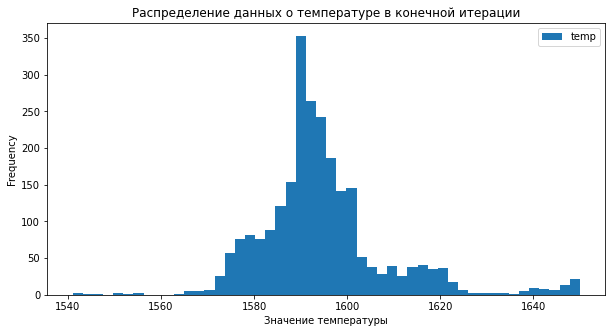

In [48]:
plt.figure(figsize=(10,5))
data_temp_pivot['temp'].plot(kind='hist', bins=50, legend=True)

plt.title('Распределение данных о температуре в конечной итерации')

plt.xlabel('Значение температуры')
plt.show()

Распределение целевого признака имеет нормальный вид, что важно для дальнейшего обучения модели!

### Данные о проволочных материалах (объём);

In [49]:
data_info(data_wire)

ОБЩАЯ ИНФОРМАЦИЯ
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
 
ДАННЫЕ ТАБЛИЦЫ


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


 
ОПИСАТЕЛЬНАЯ СТАТИСТИКА


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


 
КОЛИЧЕСТВО ДУБЛИКАТОВ


0

 
КОЛИЧЕСТВО ПРОПУСКОВ


key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

Файл *data_wire* с информацией о подаче проволоки через специальный трайб-аппарат:
- пропуски в данных присутствуют (что логично, тк добавляют то или иное количество)
- дубликаты отсутствуют
- 3081 строк
- партии от 1 до 3241 (значит не во все партии шли добавки) 
- столбцы содержат информацию об объеме той или иной проволки 
- разве что по *Wire 5* может быть вопрос - представлен в количестве 1 строки (но на результате вряд ли скажется)
- судить о выбросах довольно сложно, тк нет информации об изначальных сплавах и о проволках

**Посмотрим графически:**

array([[<AxesSubplot:title={'center':'Wire 1'}>,
        <AxesSubplot:title={'center':'Wire 2'}>,
        <AxesSubplot:title={'center':'Wire 3'}>],
       [<AxesSubplot:title={'center':'Wire 4'}>,
        <AxesSubplot:title={'center':'Wire 5'}>,
        <AxesSubplot:title={'center':'Wire 6'}>],
       [<AxesSubplot:title={'center':'Wire 7'}>,
        <AxesSubplot:title={'center':'Wire 8'}>,
        <AxesSubplot:title={'center':'Wire 9'}>]], dtype=object)

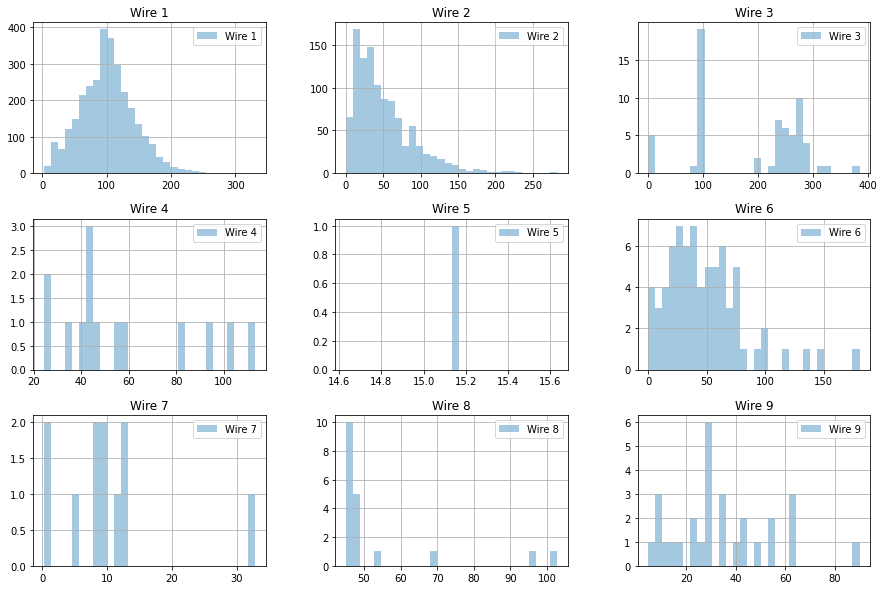

In [51]:
columns = data_wire.drop(columns = 'key')
columns.hist(bins=30, figsize=(15,10),legend=True,  alpha=0.4)

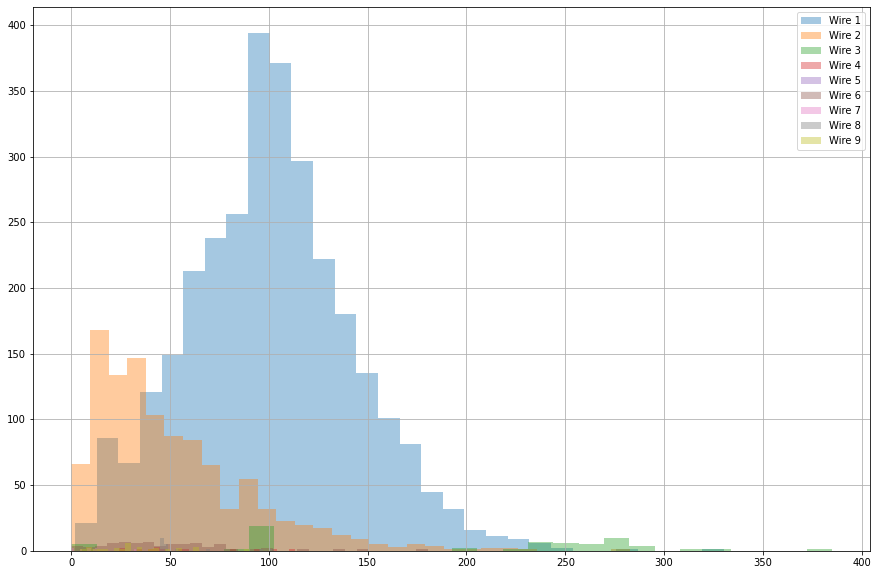

In [52]:
for column in data_wire.columns:
    if column[0] == 'W':
        data_wire[column].hist(bins=30, figsize=(15,10),legend=True,  alpha=0.4)

In [53]:
#заменим пропуски на ноль
data_wire = data_wire.fillna(0)

In [54]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


array([[<AxesSubplot:title={'center':'Wire 1'}>,
        <AxesSubplot:title={'center':'Wire 2'}>,
        <AxesSubplot:title={'center':'Wire 3'}>],
       [<AxesSubplot:title={'center':'Wire 4'}>,
        <AxesSubplot:title={'center':'Wire 5'}>,
        <AxesSubplot:title={'center':'Wire 6'}>],
       [<AxesSubplot:title={'center':'Wire 7'}>,
        <AxesSubplot:title={'center':'Wire 8'}>,
        <AxesSubplot:title={'center':'Wire 9'}>]], dtype=object)

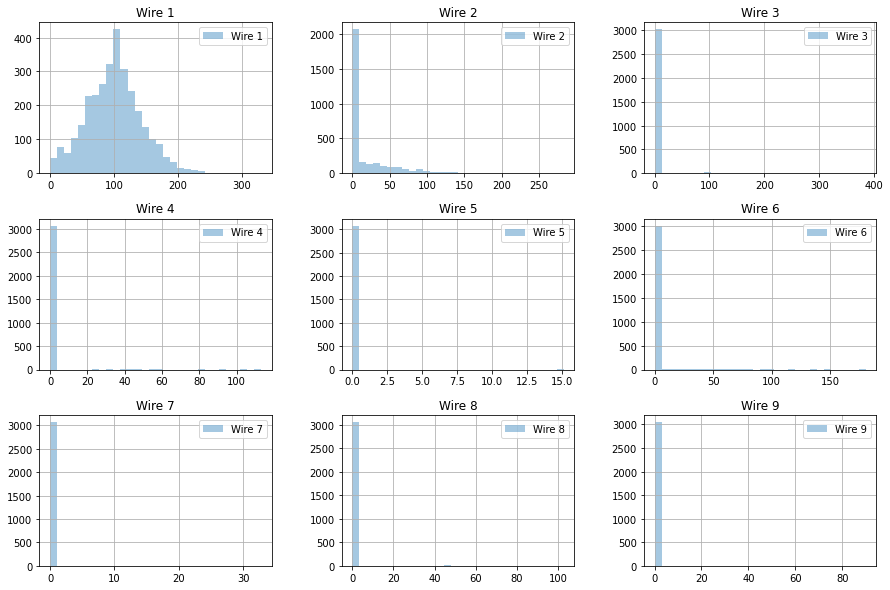

In [55]:
columns = data_wire.drop(columns = 'key')
columns.hist(bins=30, figsize=(15,10),legend=True,  alpha=0.4)

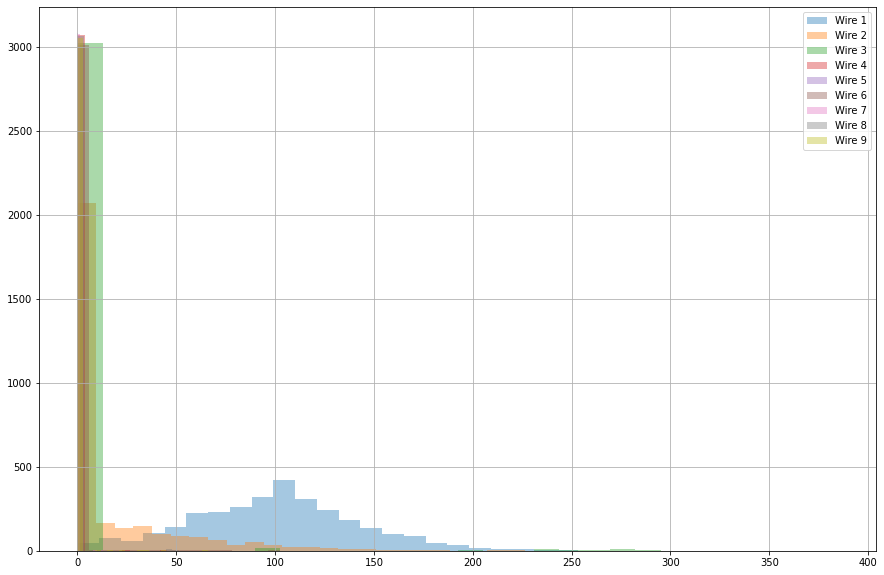

In [56]:
#еще раз посмотрим на гистограмму
for column in data_wire.columns:
    if column[0] == 'W':
        data_wire[column].hist(bins=30, figsize=(15,10),legend=True,  alpha=0.4)

**Посмотрим на корреляцию признаков:**

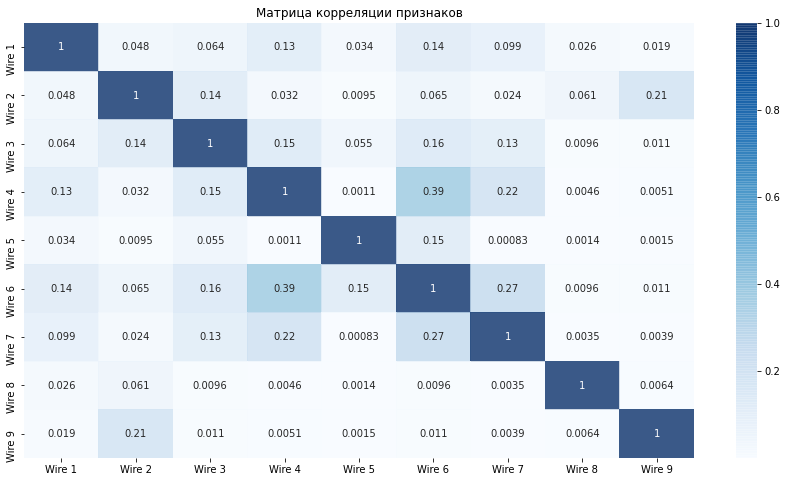

In [57]:
plt.figure(figsize=(15, 8))
sns.heatmap(data_wire.drop(columns='key').corr().abs(), cmap='Blues', alpha=0.8,
           annot=True);
plt.title('Матрица корреляции признаков')
plt.show()

Корреляции не наблюдается, **НО** есть проволочные материалы, которых, согласно info и hist, больше по объему и которые могут сыграть большую роль в предсказании и обучении модели:

- Wire 1, Wire 2.

Оставим только их:

In [58]:
data_wire = data_wire[['key', 'Wire 1','Wire 2']]
data_wire

,key,Wire 1,Wire 2
0,1,60.059998,0.00000
1,2,96.052315,0.00000
2,3,91.160157,0.00000
3,4,89.063515,0.00000
4,5,89.238236,9.11456
...,...,...,...
3076,3237,38.088959,0.00000
3077,3238,56.128799,0.00000
3078,3239,143.357761,0.00000
3079,3240,34.070400,0.00000


### Данные о проволочных материалах (время)

In [59]:
data_info(data_wire_time)

ОБЩАЯ ИНФОРМАЦИЯ
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
 
ДАННЫЕ ТАБЛИЦЫ


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:59:02,2019-05-03 13:59:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:28:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:03:42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:42:43,2019-05-03 15:58:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:20:25,2019-05-03 16:21:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN


 
ОПИСАТЕЛЬНАЯ СТАТИСТИКА


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


 
КОЛИЧЕСТВО ДУБЛИКАТОВ


0

 
КОЛИЧЕСТВО ПРОПУСКОВ


key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

Файл *data_wire_time* с информацией о времени подачи проволоки:
- пропуски в данных присутствуют (что логично, тк добавляют то или иное количество)
- дубликаты отсутствуют
- 3081 строк
- партии от 1 до 3241 (значит не во все партии шли добавки) 

**Необходимость** данной таблицы в дальнейшем под вопрсом. Для обучения модели вряд ли пригодится! Нет смысла в обработке пропусков или выборе тех или иных Wire (как в data_wire).

## Получение единой таблицы данных:

In [60]:
data = data_arc_merge.merge(data_bulk, how='inner', on='key')
data = data.merge(data_gas, how='inner', on='key')
data = data.merge(data_temp_pivot, how='inner', on='key')
data = data.merge(data_wire, how='inner', on='key')
data

,key,duration_heat_sec,count_heat,full_power,ratio_act_react,Bulk 3,Bulk 4,Bulk 12,Bulk 14,Bulk 15,gas,temp_start,temp,Wire 1,Wire 2
0,1,1098.0,5,1.165279,1.538898,0.0,43.0,206.0,150.0,154.0,29.749986,1571.0,1613.0,60.059998,0.00000
1,2,811.0,4,0.912304,1.551834,0.0,73.0,206.0,149.0,154.0,12.555561,1577.0,1602.0,96.052315,0.00000
2,3,655.0,5,0.597907,1.583120,0.0,34.0,205.0,152.0,153.0,28.554793,1596.0,1599.0,91.160157,0.00000
3,4,741.0,4,0.953741,1.563487,0.0,81.0,207.0,153.0,154.0,18.841219,1601.0,1625.0,89.063515,0.00000
4,5,869.0,4,1.008939,1.480428,0.0,78.0,203.0,151.0,152.0,5.413692,1576.0,1602.0,89.238236,9.11456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,2495,723.0,4,0.996717,1.372734,21.0,0.0,256.0,129.0,223.0,7.125735,1570.0,1591.0,89.150879,0.00000
2325,2496,940.0,6,0.842839,1.491059,0.0,63.0,256.0,129.0,226.0,9.412616,1554.0,1591.0,114.179527,0.00000
2326,2497,569.0,3,0.961672,1.192036,0.0,85.0,230.0,124.0,226.0,6.271699,1571.0,1589.0,94.086723,9.04800
2327,2498,750.0,5,0.828750,1.470072,90.0,0.0,206.0,129.0,207.0,14.953657,1570.0,1594.0,118.110717,0.00000


In [61]:
#проверим пропуски
display(data.isnull().sum())

key                  0
duration_heat_sec    0
count_heat           0
full_power           0
ratio_act_react      0
Bulk 3               0
Bulk 4               0
Bulk 12              0
Bulk 14              0
Bulk 15              0
gas                  0
temp_start           0
temp                 0
Wire 1               0
Wire 2               0
dtype: int64

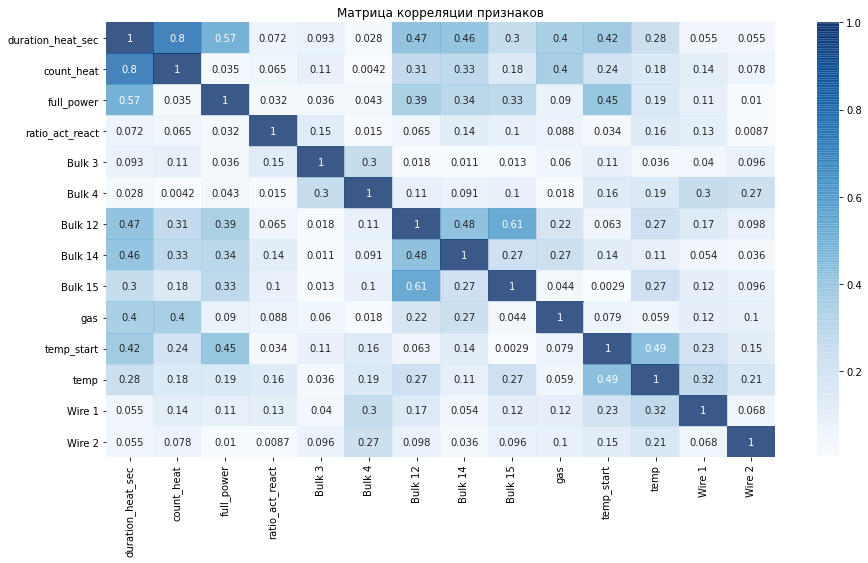

In [62]:
plt.figure(figsize=(15, 8))
sns.heatmap(data.drop(columns='key').corr().abs(), cmap='Blues', alpha=0.8,
           annot=True);
plt.title('Матрица корреляции признаков')
plt.show()



In [63]:
display(data.describe())

,key,duration_heat_sec,count_heat,full_power,ratio_act_react,Bulk 3,Bulk 4,Bulk 12,Bulk 14,Bulk 15,gas,temp_start,temp,Wire 1,Wire 2
count,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000
mean,1251.832546,807.600687,4.695148,0.836618,1.361393,47.348218,37.303564,208.415629,153.853585,119.952769,11.375600,1576.958781,1593.360240,102.443601,17.609859
std,714.762400,340.897332,1.606948,0.242350,0.131502,75.310430,58.643238,157.062272,81.404354,84.640443,6.392041,15.685072,11.176204,43.539993,33.624771
min,1.000000,57.000000,1.000000,0.228541,0.687735,0.000000,0.000000,0.000000,0.000000,0.000000,0.008399,1519.000000,1541.000000,0.000000,0.000000
25%,630.000000,581.000000,4.000000,0.659957,1.294044,0.000000,0.000000,105.000000,105.000000,0.000000,7.282948,1568.000000,1587.000000,73.207679,0.000000
50%,1255.000000,778.000000,5.000000,0.815558,1.373416,0.000000,0.000000,206.000000,149.000000,107.000000,10.100950,1579.000000,1593.000000,101.119201,0.000000
75%,1868.000000,993.000000,6.000000,0.986384,1.441510,80.000000,77.000000,282.000000,204.000000,204.000000,14.216688,1588.000000,1598.000000,128.091599,23.102560
max,2499.000000,4189.000000,16.000000,1.796257,1.782164,454.000000,281.000000,1849.000000,636.000000,405.000000,77.995040,1629.000000,1647.000000,330.314424,282.780152


Наблюдается корреляция между временем нагрева в секундах от количества запусков нагрева.

В дальнейшем обучении модели могут дать ошибочные прогнозы. В дальнейшем посмотрим!


Данные предобработаны!!! Все необходимые признаки собрали в итоговую таблицу.

## Подготовка признаков

**Выделим тестовую и тренировочную выборки**

Данные были подготовлены для обучения модели.
Выделим целевой признак конечной температуры 'temp'. Остальные столбцы будем использованы для предсказания.
Разобьем данные на train и test к соотношению 80/20.

In [64]:
data

,key,duration_heat_sec,count_heat,full_power,ratio_act_react,Bulk 3,Bulk 4,Bulk 12,Bulk 14,Bulk 15,gas,temp_start,temp,Wire 1,Wire 2
0,1,1098.0,5,1.165279,1.538898,0.0,43.0,206.0,150.0,154.0,29.749986,1571.0,1613.0,60.059998,0.00000
1,2,811.0,4,0.912304,1.551834,0.0,73.0,206.0,149.0,154.0,12.555561,1577.0,1602.0,96.052315,0.00000
2,3,655.0,5,0.597907,1.583120,0.0,34.0,205.0,152.0,153.0,28.554793,1596.0,1599.0,91.160157,0.00000
3,4,741.0,4,0.953741,1.563487,0.0,81.0,207.0,153.0,154.0,18.841219,1601.0,1625.0,89.063515,0.00000
4,5,869.0,4,1.008939,1.480428,0.0,78.0,203.0,151.0,152.0,5.413692,1576.0,1602.0,89.238236,9.11456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,2495,723.0,4,0.996717,1.372734,21.0,0.0,256.0,129.0,223.0,7.125735,1570.0,1591.0,89.150879,0.00000
2325,2496,940.0,6,0.842839,1.491059,0.0,63.0,256.0,129.0,226.0,9.412616,1554.0,1591.0,114.179527,0.00000
2326,2497,569.0,3,0.961672,1.192036,0.0,85.0,230.0,124.0,226.0,6.271699,1571.0,1589.0,94.086723,9.04800
2327,2498,750.0,5,0.828750,1.470072,90.0,0.0,206.0,129.0,207.0,14.953657,1570.0,1594.0,118.110717,0.00000


In [65]:
features = data.drop(columns=['key','temp', 'count_heat'], axis=1)
target = data['temp']

In [66]:
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, test_size=0.20, 
                                                                            random_state=12092022, shuffle=True)

In [67]:
len(features_train)

1863

In [68]:
len(features_test)

466

In [82]:
#from sklearn.preprocessing import StandardScaler

In [83]:
##scaler = StandardScaler()
#features_train = pd.DataFrame(scaler.fit_transform(features_train), columns = features_train.columns)
#features_test = pd.DataFrame(scaler.transform(features_test), columns = features_test.columns)

In [69]:
features_train.head()

,duration_heat_sec,full_power,ratio_act_react,Bulk 3,Bulk 4,Bulk 12,Bulk 14,Bulk 15,gas,temp_start,Wire 1,Wire 2
958,971.0,1.017354,1.369327,168.0,0.0,364.0,209.0,189.0,8.313330,1545.0,136.047598,0.000000
1011,893.0,0.923862,1.278172,21.0,0.0,0.0,140.0,0.0,13.804327,1572.0,61.073997,72.263359
978,818.0,0.927297,1.456082,0.0,0.0,0.0,154.0,0.0,8.814979,1576.0,95.050797,0.000000
246,1222.0,1.069265,1.225117,0.0,0.0,0.0,307.0,0.0,10.522430,1574.0,61.152000,90.184647
772,448.0,0.649159,1.244479,0.0,0.0,129.0,130.0,103.0,11.133610,1579.0,68.187599,0.000000


In [70]:
target_train.head()

958     1593.0
1011    1587.0
978     1592.0
246     1592.0
772     1579.0
Name: temp, dtype: float64

**Выберем следующие модели для задачи регрессии:**
- RandomForestRegressor
- LinearRegression
- LGBMRegressor
- CatBoostRegressor

**Используем подбор параметров только с использованием GridSearchCV**

### RandomForestRegressor

Кросс-валидация заложена в GridSearch с помощью параметра cv = 5. 
- Обучим модель
- Найдем параметры
- Посчитаем МАE на тренировочной выборке

In [71]:
#найдем лучшие параметры для модели
from sklearn.ensemble import RandomForestRegressor
def rf_regr(features, target):
    model = RandomForestRegressor(random_state=12092022)
    params = {'n_estimators':[10, 50, 100], 'max_depth':[10, 20, 30]}
    grid_cv = GridSearchCV(estimator = model, param_grid = params, cv = 5, n_jobs = -1, scoring = 'neg_mean_absolute_error')
    grid_cv.fit(features, target)
    print('Best hyperparams: ', grid_cv.best_params_)
    return grid_cv.best_params_

In [72]:
rf_params = rf_regr(features_train, target_train)

Best hyperparams:  {'max_depth': 20, 'n_estimators': 50}


In [73]:
model_rf = RandomForestRegressor(**rf_params)

In [74]:
%%time
model_rf.fit(features_train,target_train)

CPU times: user 463 ms, sys: 198 µs, total: 464 ms
Wall time: 462 ms


RandomForestRegressor(max_depth=20, n_estimators=50)

In [76]:
MAE_rf = round(mean_absolute_error(target_train, model_rf.predict(features_train)), 2)
print(color.BOLD + 'MAE на тренировочной выборке для RandomForestRegressor:' + color.END, MAE_rf)    

MAE на тренировочной выборке для RandomForestRegressor: 1.74


Посмотрим на график предсказаний и истинных значений:

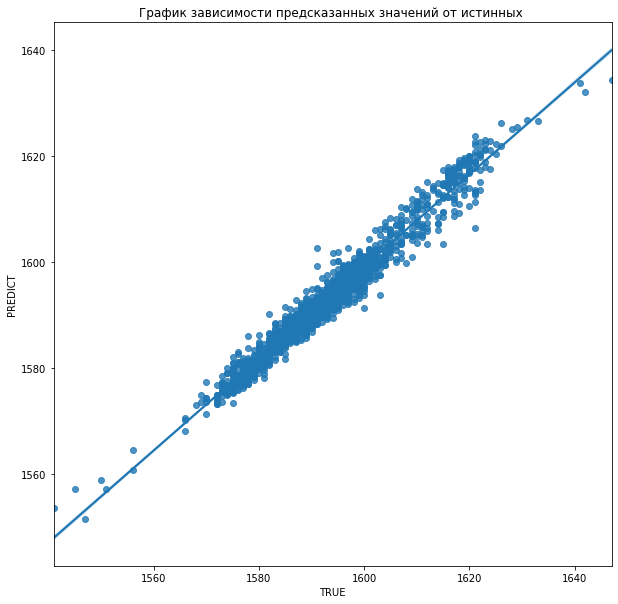

In [77]:
plt.figure(figsize=(10,10))
sns.regplot(x = target_train, y = model_rf.predict(features_train))
plt.title('График зависимости предсказанных значений от истинных ')
plt.ylabel('PREDICT')
plt.xlabel('TRUE')
plt.show()

С учетом MAE менее 2 мы получили максимально линейную зависимость.

### LinearRegression

In [78]:
#найдем лучшие параметры для модели
def l_regr(features, target):
    model = LinearRegression()
    params = { 'fit_intercept': [True, False],
              'normalize': [True, False]}
    grid_cv = GridSearchCV(estimator = model, param_grid = params, cv = 5, n_jobs = -1, scoring = 'neg_mean_absolute_error')
    grid_cv.fit(features, target)
    print('Best hyperparams: ', grid_cv.best_params_)
    return grid_cv.best_params_

In [79]:
l_params = l_regr(features_train, target_train)

Best hyperparams:  {'fit_intercept': True, 'normalize': False}


In [80]:
model_l = LinearRegression(**l_params)

In [81]:
%%time
model_l.fit(features_train,target_train)

CPU times: user 2.45 ms, sys: 3.84 ms, total: 6.29 ms
Wall time: 4.58 ms


LinearRegression()

In [82]:
MAE_l = round(mean_absolute_error(target_train, model_l.predict(features_train)), 2)
print(color.BOLD + 'MAE на тренировочной выборке для LinearRegression:' + color.END, MAE_l)  

MAE на тренировочной выборке для LinearRegression: 4.99


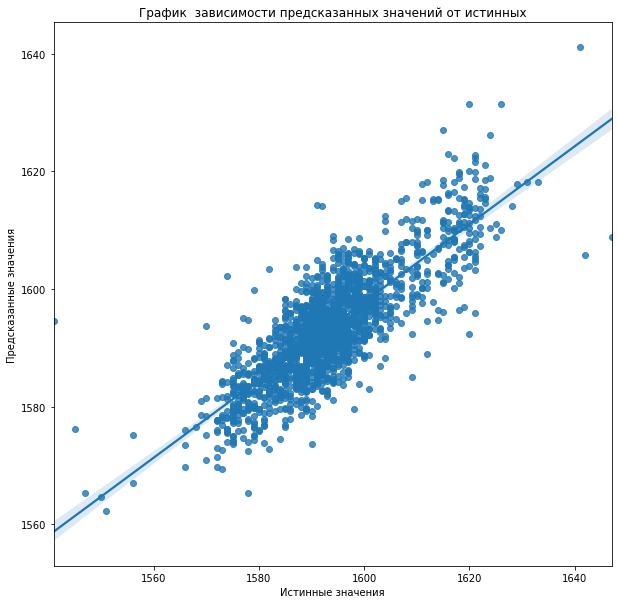

In [83]:
plt.figure(figsize=(10,10))
sns.regplot(x = target_train, y=model_l.predict(features_train))
plt.title('График  зависимости предсказанных значений от истинных')
plt.ylabel('Предсказанные значения')
plt.xlabel('Истинные значения')
plt.show()

### LGBMRegressor

In [86]:
#найдем лучшие параметры для модели
def lgbm_regr(features, target):
    model = LGBMRegressor(random_state=12092022)
    params = {
        'boosting_type' : ['gbdt'],
        'max_depth' : [3, 5, 7, 10],
        'learning_rate': [0.01, 0.03, 0.1, 0.2],
        'n_estimators' : range(10, 50, 10)
        }
        
    grid_cv = GridSearchCV(estimator=model, param_grid=params, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')
    grid_cv.fit(features, target)
    print('Best hyperparams: ', grid_cv.best_params_)
    return grid_cv.best_params_

In [87]:
lgbm_params = lgbm_regr(features_train, target_train)

Best hyperparams:  {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 40}


In [88]:
model_lgbm = LGBMRegressor(**lgbm_params)

In [89]:
%%time
model_lgbm.fit(features_train,target_train)

CPU times: user 2.28 s, sys: 20.9 ms, total: 2.3 s
Wall time: 2.24 s


LGBMRegressor(max_depth=10, n_estimators=40)

In [90]:
MAE_lgbm = round(mean_absolute_error(target_train, model_lgbm.predict(features_train)), 2)
print(color.BOLD + 'MAE на тренировочной выборке для LGBMRegressor:' + color.END, MAE_lgbm)  

MAE на тренировочной выборке для LGBMRegressor: 3.03


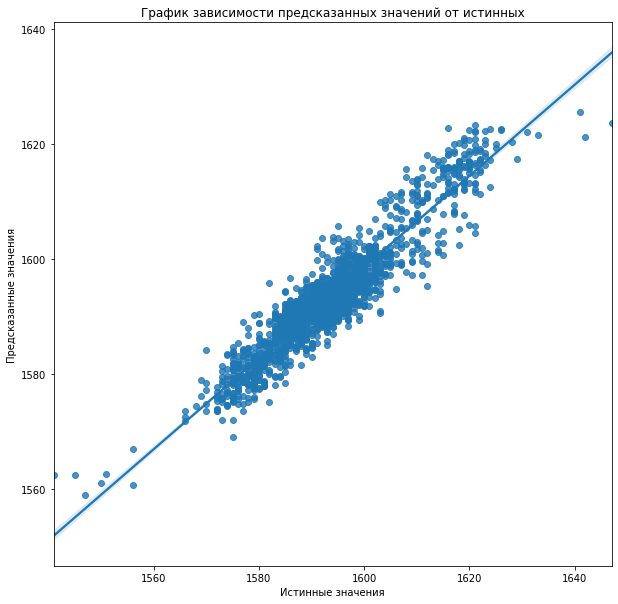

In [91]:
plt.figure(figsize=(10,10))
sns.regplot(x = target_train, y=model_lgbm.predict(features_train))
plt.title('График зависимости предсказанных значений от истинных')
plt.ylabel('Предсказанные значения')
plt.xlabel('Истинные значения')
plt.show()

### CatBoostRegressor

In [94]:
#найдем лучшие параметры для модели
def catboost_regr(features, target):
    model = CatBoostRegressor(random_state = 12092022)
    params = {
            'learning_rate':[0.01, 0.1, 1],        
            'max_depth' : [5, 7, 10],
            'n_estimators' : [10, 50, 100]
    }
    

    
    grid_cv = GridSearchCV(estimator=model, 
    param_grid=params, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')
    grid_cv.fit(features, target)
    print('Лучшие параметры: ', grid_cv.best_params_)
    return grid_cv.best_params_

In [95]:
cb_params = catboost_regr(features_train, target_train)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 11.3893894	total: 1.63ms	remaining: 14.7ms
1:	learn: 11.3429862	total: 3.49ms	remaining: 13.9ms
2:	learn: 11.2962179	total: 5.13ms	remaining: 12ms
3:	learn: 11.2514166	total: 6.85ms	remaining: 10.3ms
4:	learn: 11.2023820	total: 8.41ms	remaining: 8.41ms
5:	learn: 11.1522811	total: 10.1ms	remaining: 6.76ms
6:	learn: 11.1062202	total: 12.1ms	remaining: 5.2ms
7:	learn: 11.0701286	total: 14.3ms	remaining: 3.56ms
8:	learn: 11.0328662	total: 16.1ms	remaining: 1.79ms
9:	learn: 10.9903303	total: 17.7ms	remaining: 0us
0:	learn: 11.0595727	total: 1.8ms	remaining: 16.2ms
1:	learn: 11.0167279	total: 3.48ms	remaining: 13.9ms
2:	learn: 10.9667901	total: 5.11ms	remaining: 11.9ms
3:	learn: 10.9278309	total: 6.65ms	remaining: 9.97ms
4:	learn: 10.8790020	total: 8.6ms	remaining: 8.6ms
5:	learn: 10.8309544	total: 10.2ms	remaining: 6.77ms
6:	learn: 10.7884345	total: 11.8ms	remaining: 5.04ms
7:	learn: 10.7487193	total: 13.2ms	remaining: 3.31ms
8:	learn: 10.7126335	total: 14.9ms	remaining: 1.66ms
9:

In [96]:
model_cb = CatBoostRegressor(**cb_params)

In [97]:
%time
model_cb.fit(features_train, target_train)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs
0:	learn: 10.8296279	total: 1.82ms	remaining: 180ms
1:	learn: 10.4264587	total: 3.72ms	remaining: 182ms
2:	learn: 10.0545033	total: 5.5ms	remaining: 178ms
3:	learn: 9.8001144	total: 7.18ms	remaining: 172ms
4:	learn: 9.4557143	total: 8.79ms	remaining: 167ms
5:	learn: 9.2315227	total: 10.5ms	remaining: 164ms
6:	learn: 8.9660249	total: 12ms	remaining: 160ms
7:	learn: 8.6870677	total: 13.7ms	remaining: 157ms
8:	learn: 8.4849141	total: 15.2ms	remaining: 154ms
9:	learn: 8.2799665	total: 16.8ms	remaining: 151ms
10:	learn: 8.0842825	total: 18.4ms	remaining: 149ms
11:	learn: 7.9576563	total: 20ms	remaining: 147ms
12:	learn: 7.8060426	total: 21.7ms	remaining: 145ms
13:	learn: 7.6542686	total: 23.3ms	remaining: 143ms
14:	learn: 7.5135337	total: 24.9ms	remaining: 141ms
15:	learn: 7.4115604	total: 26.6ms	remaining: 139ms
16:	learn: 7.3029655	total: 28.1ms	remaining: 137ms
17:	learn: 7.1954532	total: 29.8ms	remaining: 136ms
18:	learn: 7

In [98]:
MAE_cb= round(mean_absolute_error(target_train, model_cb.predict(features_train)), 2)
print(color.BOLD + 'MAE на тренировочной выборке для CatBoostRegressor:' + color.END, MAE_cb)  

MAE на тренировочной выборке для CatBoostRegressor: 3.89


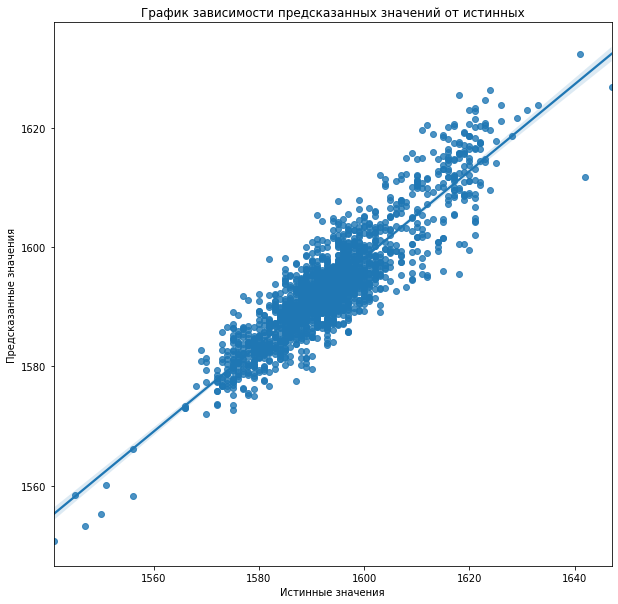

In [99]:
plt.figure(figsize=(10,10))
sns.regplot(x = target_train, y=model_cb.predict(features_train))
plt.title('График зависимости предсказанных значений от истинных')
plt.ylabel('Предсказанные значения')
plt.xlabel('Истинные значения')
plt.show()

**Посмотрим на ИТОГИ предсказаний моделей:**

In [104]:
final_info = pd.DataFrame(columns = ['RandomForest','Linear','LightGBM','CatBoost'],
                      index = ['MAE(train)','Время обучения'])

final_info.iloc[0] = [MAE_rf, MAE_l, MAE_lgbm, MAE_cb]
final_info.iloc[1] = ['462ms', '4.58ms', '2.24s', '5.72mks']
display(final_info)

,RandomForest,Linear,LightGBM,CatBoost
MAE(train),1.74,4.99,3.03,3.89
Время обучения,462ms,4.58ms,2.24s,5.72mks


### Тестирование наилучшей модели

Результаты предсказания на тренировочной выборке показывают неплохие результаты для всех моделей. Однако, быстрее всех проихсодит обучение CatBoost. Проведем тестирование модели:

In [105]:
test_predict = model_cb.predict(features_test)
MAE = mean_absolute_error(target_test, test_predict)
print('MAE на тестовой выборке=', MAE)

MAE на тестовой выборке= 4.6137807680782


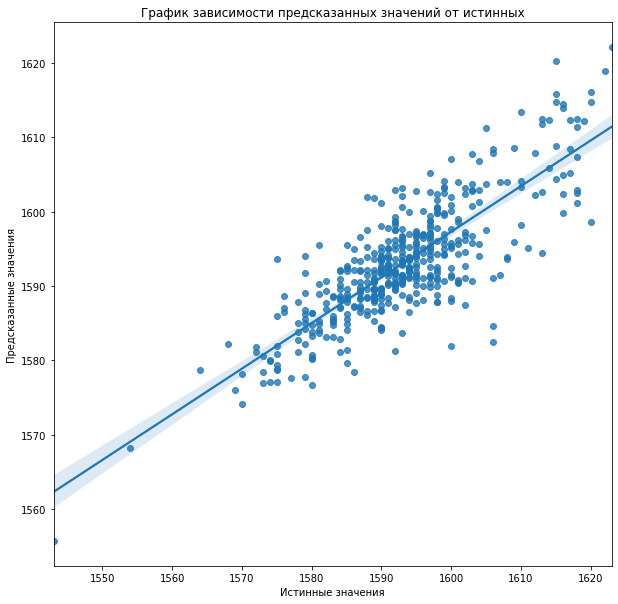

In [106]:
plt.figure(figsize=(10,10))
sns.regplot(x = target_test, y=model_cb.predict(features_test))
plt.title('График зависимости предсказанных значений от истинных')
plt.ylabel('Предсказанные значения')
plt.xlabel('Истинные значения')
plt.show()

**Проверим важность признаков для итоговой модели (возможно какие-то признаки можно считать лишними):**

In [107]:
importances = model_cb.feature_importances_

feature_list = list(features_test.columns)
feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})
feature_results = feature_results.sort_values('importance',ascending = False).reset_index(drop=True)
feature_results.head(10)

,feature,importance
0,temp_start,47.235060
1,duration_heat_sec,20.605032
2,full_power,9.857958
3,Wire 1,6.097673
4,Bulk 12,2.857752
5,Wire 2,2.803079
6,ratio_act_react,2.665960
7,Bulk 14,2.598533
8,Bulk 15,2.025383
9,gas,1.497771


По результатам проверки можно сделать вывод, что наиболее важные признаки, на которых строилось предсказание лучшей модели:
- temp_start (температура в начале замера)
- duration_heat_sec (длительность нагрева)
- full_power (полная мощность,  потраченная при нагреве стали дугой)

## Выводы

Была проведена предобработка данных, проведено разделение данных на обучающую и тестовую выборки в соотношении 80/20. Далее проведено обучение моделей RandomForestRegression, LinearRegression, LGBMRegressor и CatBoostRegressor и использованием GridSearchCV по подбору оптимальных параметров обучения.

Сравнение метрик качества предсказаний МАЕ показало, что лидируют СatBoostRegressor дает наилучший результат: модель в среднем ошибается на 4-5 градусов температуры. 

Дополнительно проверили наиболее важные данные, на которых строилось предсказание модели.

## ОТЧЕТ

По итогу проделанной работы посмотрим на отчет:

- **Какие пункты плана были выполнены, а какие — нет (поясните почему)?**

Все пункты плана выполнены в полном объеме (многое аналогично прошлым спринт-проектам): подготовка данных, создание признаков, разбиение на тренировочную и тестовую выборки, подбор гиперпараметров для выбранных регрессионных моделей, проверка лучшей модели.
       
    //Не проведена работа над датасетами bulk_time и wire_time, которые не являются необходимыми для проекта. Возможно расширение перечня моделей, но и без того получилась очень хорошая метрика!//    

- **Какие трудности возникли и как вы их преодолели?**

Возникшие трудности были связаны с поиском правильной информации о выделенной части сталепромышленности - понимание процесса, углубление в понятия. Обязательно стоит отметить возникшую трудность по удалению ненужных строк в data_temp (когда нач темп = конечн темп): проблема была решена только путем получения подсказки от ревьюера (!!!). Возникла трудность с недоверием к результату по моделям на тренировочной выборке: решением стала многократное перепроверка предобработки и исследовательского анализа (но! надо уметь доверять себе и своим результатам!!!)

- **Какие ключевые шаги в решении задачи выделили?**

1. Понимание процесса сталепромышленности
2. Предобработка данных
3. Исследовательский анализ - изучение мультиколлинеарности параметров в нескольких таблица + в единой + перепроверка подготовленных данных несколько раз, чтоб понимать, что учтено всё!
4. Подготовка тестовой и тренировочной выборок (правильный выбор признаков, удаление key)
5. Подготовка и построение модели
6. Тестирование модели и проверка ее на адекватность

- **Какая ваша итоговая модель и какое у неё качество?**

Итоговой моделью стал СatBoostRegressor, который дает наилучший результат: модель в среднем ошибается на 4-5 градусов температуры.

Дополнительно стоит отметить, что для этой модели анализ важности признаков показал, что наиболее важные признаки, на которых строилось ее предсказание temp_start (температура в начале замера), duration_heat_sec (длительность нагрева), full_power (полная мощность, потраченная при нагреве стали дугой).

Это говорит о том, что даже при проведенном анализе данных до этапа тестирования модели неекоторые переменные можно считать ненужными/лишними/усложняющими обучение. И если отбросить их как некий шум из анализа, то при решении задачи, мы придем к аналогичному результату!!!

MAE на тренировочной выборке= 3,89

MAE на тестовой выборке= 4.61